# Race with Bayes
### MTH 448 Project 4
#### Alison Casson

Each year, tens of thousands of runners participate in marathons, generating rich data on finishing times, ages, and demographics. This project explores whether such data can be used to infer more about the runners—specifically, their gender.


## What is Bayes' Theorem?
Bayes’ Theorem, a fundamental principle in probability theory that allows us to update our beliefs based on observed evidence. In this case, we use it to compute the probability that a runner is female (or male), given their finishing time.

Bayes' Theorem:

$$
P(A \mid B) = \frac{P(B \mid A) \cdot P(A)}{P(B)}
$$

- \( P(A) \) and \( P(B) \) are the probabilities of events \( A \) and \( B \); also, \( P(B) \neq 0 \)
- \( P(A|B) \) is the probability of event \( A \) given that event \( B \) occurs
- \( P(B|A) \) is the probability of event \( B \) given that event \( A \) occurs


## What is a KDE?
KDE stands for "Kernel Density Estimates."



## Project Goals
This project aims to use Bayes’ Theorem, combined with kernel density estimation (KDE), to classify the gender of runners based on their finish times. We begin by evaluating the performance of 1-dimensional KDE using only finishing times, then extend the analysis to 2-dimensional KDE incorporating age as well. Finally, we compare the effectiveness of Bayes-based classification to that of a k-Nearest Neighbors (k-NN) approach.

In [241]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

## Part 1: Split the Data
Splitting the data allows you to evaluate how well the model performs on unseen data. For this project, it helps assess how well the model generalizes new runners.

### Methodology
1. Create the Data Frame
2. Convert times to minutes
3. Randomly divide the marathon dataset into training and testing sets.

In [243]:
df = pd.read_csv("marathon_results.csv")              # Load the `marathon_results` CSV file into a pandas DataFrame

In [244]:
df

,Age,M/F,Country,5K,10K,15K,20K,Half,25K,30K,35K,40K,Finish,Pace,Overall,Gender,Division
0,25,M,ETH,00:14:43,00:29:43,00:44:57,01:00:29,01:04:02,01:16:07,01:32:00,01:47:59,02:02:39,02:09:17,00:04:56,1,1,1
1,30,M,ETH,00:14:43,00:29:43,00:44:58,01:00:28,01:04:01,01:16:07,01:31:59,01:47:59,02:02:42,02:09:48,00:04:58,2,2,2
2,29,M,KEN,00:14:43,00:29:43,00:44:57,01:00:29,01:04:02,01:16:07,01:32:00,01:47:59,02:03:01,02:10:22,00:04:59,3,3,3
3,28,M,KEN,00:14:43,00:29:44,00:45:01,01:00:29,01:04:02,01:16:07,01:32:00,01:48:03,02:03:47,02:10:47,00:05:00,4,4,4
4,32,M,KEN,00:14:43,00:29:44,00:44:58,01:00:28,01:04:01,01:16:07,01:32:00,01:47:59,02:03:27,02:10:49,00:05:00,5,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26293,64,F,USA,00:50:15,01:43:31,02:36:53,03:32:26,03:43:46,04:25:53,05:19:44,06:17:19,07:13:34,07:38:56,00:17:31,26594,12015,269
26294,61,F,USA,00:48:36,01:39:39,02:39:13,03:35:58,03:47:55,04:32:44,05:31:58,06:28:56,07:26:19,07:51:30,00:17:59,26595,12016,270
26295,66,F,USA,00:53:03,01:47:16,02:41:45,03:37:07,03:48:21,04:33:51,05:38:56,06:38:51,07:36:18,07:59:33,00:18:18,26596,12017,91
26296,53,M,USA,00:49:04,01:40:12,02:33:31,03:31:41,03:43:35,04:29:20,05:31:11,06:33:35,07:35:38,08:00:37,00:18:20,26597,14580,2055


In [245]:
def TimeStrToMins(TimeStr):                                                    # Convert the times in the csv file from HH:MM:SS to minutes
    TimeList=TimeStr.split(':')                                                # Split the times into a list of [hours, minutes, seconds]
    mins = int(TimeList[0]) * 60 + int(TimeList[1]) + int(TimeList[2]) / 60    # Convert hours to minutes, add minutes, and convert seconds to fractional minutes
    return mins                                                                # Return the total time in minutes

In [246]:
df['Time(mins)'] = df['Finish'].map(TimeStrToMins)

In [247]:
df

,Age,M/F,Country,5K,10K,15K,20K,Half,25K,30K,35K,40K,Finish,Pace,Overall,Gender,Division,Time(mins)
0,25,M,ETH,00:14:43,00:29:43,00:44:57,01:00:29,01:04:02,01:16:07,01:32:00,01:47:59,02:02:39,02:09:17,00:04:56,1,1,1,129.283333
1,30,M,ETH,00:14:43,00:29:43,00:44:58,01:00:28,01:04:01,01:16:07,01:31:59,01:47:59,02:02:42,02:09:48,00:04:58,2,2,2,129.800000
2,29,M,KEN,00:14:43,00:29:43,00:44:57,01:00:29,01:04:02,01:16:07,01:32:00,01:47:59,02:03:01,02:10:22,00:04:59,3,3,3,130.366667
3,28,M,KEN,00:14:43,00:29:44,00:45:01,01:00:29,01:04:02,01:16:07,01:32:00,01:48:03,02:03:47,02:10:47,00:05:00,4,4,4,130.783333
4,32,M,KEN,00:14:43,00:29:44,00:44:58,01:00:28,01:04:01,01:16:07,01:32:00,01:47:59,02:03:27,02:10:49,00:05:00,5,5,5,130.816667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26293,64,F,USA,00:50:15,01:43:31,02:36:53,03:32:26,03:43:46,04:25:53,05:19:44,06:17:19,07:13:34,07:38:56,00:17:31,26594,12015,269,458.933333
26294,61,F,USA,00:48:36,01:39:39,02:39:13,03:35:58,03:47:55,04:32:44,05:31:58,06:28:56,07:26:19,07:51:30,00:17:59,26595,12016,270,471.500000
26295,66,F,USA,00:53:03,01:47:16,02:41:45,03:37:07,03:48:21,04:33:51,05:38:56,06:38:51,07:36:18,07:59:33,00:18:18,26596,12017,91,479.550000
26296,53,M,USA,00:49:04,01:40:12,02:33:31,03:31:41,03:43:35,04:29:20,05:31:11,06:33:35,07:35:38,08:00:37,00:18:20,26597,14580,2055,480.616667


In [248]:
train,test=train_test_split(df,test_size=0.3, random_state=42)     # Split the data frame into 30% testing, 70% training

## Part 2: 1D KDE + Bayes Theorem

This part uses 1D KDE on finish times to compute that probaility that a runner is femal given their time using Bayes' Theorem. This uses probabilistic reasoning to explore how running times can predict gender. 

### Methodology
For the training set, compute KDEs of finish times for males and females.

1. Use Bayes' Theorem to compute 𝑃(Female∣Time).
2. Predict gender on the testing set using this probability.
3. Try different kernel bandwidths, compare their prediction accuracies.

In [250]:
def OneDimensionBandwith (train, test, bandwidth):                                # Define function to perform 1D KDE gender prediction
 
    timeCol= 'Time(mins)'                                                         # Sets a variable for the column showing finishing time in minutes
    FTimes = df['Time(mins)']                                                     # Gets all finishing times from the full dataset

    mTrain = train[train['M/F'] == 'M']['Time(mins)']                             # Separates training data and extracts finishing times for male runners
    fTrain = train[train['M/F'] == 'F']['Time(mins)']                             # Separates training data and extracts finishing times for female runners

    mkde = gaussian_kde(mTrain, bw_method=bandwidth)                              # Computes 1D KDE for male finish times using the given bandwidth
    fkde = gaussian_kde(fTrain, bw_method=bandwidth)                              # Computes 1D KDE for female finish times using the given bandwidth

    fp = len(fTrain) / len(train)                                                 # Computes previous probabilties of being female
    mp = 1 - fp                                                                   # Computes previous probabilties of being male
  
    times = test[timeCol].values                                                  # Extract finish times from the test set
    actual = test['M/F'].values                                                   # Extract actual genders from the test set
    predictions = []                                                              # Empty gender prediction list is created

    for i in times:                                                               # For each finish time
        fpTime = fkde(i)[0]                                                       # Apply Bayes' Theorem to female times
        mpTime = mkde(i)[0]                                                       # Apply Bayes' Theorem to male times

        denominator = fpTime * fp + mpTime * mp                                   # Total probability P(time)
        fpPrediction = (fpTime * fp) / denominator if denominator > 0 else 0      # Bayes' Theorem: P(F | time)

        predicted = 'F' if fpPrediction > 0.5 else 'M'                            # Predict female if P(F | time) > 0.5
        predictions.append(predicted)                                             # Add prediction to preditction list

    accuracy = accuracy_score(actual, predictions)                                # Calculate prediction accuracy by comparing predictions with actual genders
    print(f'Accuracy of Female: {accuracy:.4f}')                                  # Print accuracy
    
    return accuracy

In [251]:
OneDimensionBandwith(train, test, 0.3)

Accuracy of Female: 0.6539


0.6538656527249683

In [252]:
bandwidthList = [0.1, 0.2, 0.3, 0.5, 1.0, 1.5]                         # List of bandwidth values 

def differentBandwidths (train, test, bandwidthList):                  # Define a function to evaluate accuracy with different bandwidths

    accuracyList = []                             
    
    for i in bandwidthList:                                            # Loop through each bandwidth value
        a = OneDimensionBandwith (train,test, i)                       # Call the 1D KDE function with current bandwidth
        accuracyList.append(a)                                         # Append accuracy to accuracy list

                                                                       # Plot accuracy vs bandwidth
    plt.figure(figsize=(8, 5))                                         
    plt.plot(bandwidthList, accuracyList, marker='o', linewidth=2)
    plt.title('Accuracy vs Bandwidth')
    plt.xlabel('Bandwidth')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Accuracy of Female: 0.6537
Accuracy of Female: 0.6530
Accuracy of Female: 0.6539
Accuracy of Female: 0.6494
Accuracy of Female: 0.6252
Accuracy of Female: 0.6025


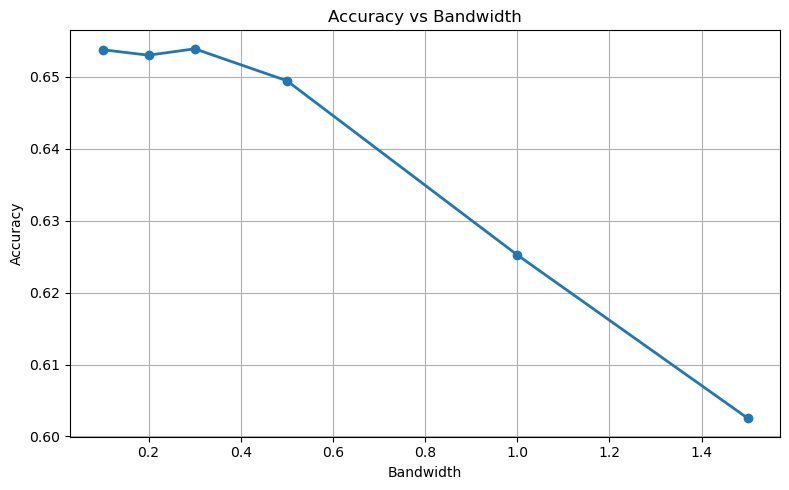

In [253]:
differentBandwidths (train, test, bandwidthList)

Looking at the graph, we can see a negative relationship between accuracy and bandwidth. As the bandwidth increases, the accuracy of the model declines. This shows that smaller bandwidths provide better predictive performance. When the bandwidth is too large, the KDEs become overly smooth, which reduces the model’s ability to distinguish between male and female runners. This over-smoothing leads to less variability in the probability distributions, making gender predictions less precise.

## Part 3: 2D KDE using Time + Age

Age of the runner is now added to compute the predictin. The 1D KDE now becomes a 2D KDE and uses two features, Age and Finishing time to predict the runners gender. Adding a second variable may increase prediction accuracy. 

### Methodology
1. Extend the model to use both finish time and age to compute 2D KDEs.
2. Predict gender using 2D KDE + Bayes' Theorem.
3. Report change in accuracy compared to the 1D case.

In [255]:
def TwoDimensionBandwith(train, test, bandwidth):                                   # Define function to perform 2D KDE gender prediction using time and age
   
    mTrain = train[train['M/F'] == 'M'][['Time(mins)', 'Age']].values.T             # Column name for time in minutes
    fTrain = train[train['M/F'] == 'F'][['Time(mins)', 'Age']].values.T             # Get all finishing times from the full dataset

    mkde = gaussian_kde(mTrain, bw_method=bandwidth)                                # Computes 2D KDE for male finish times using the given bandwidth
    fkde = gaussian_kde(fTrain, bw_method=bandwidth)                                # Computes 1D KDE for male finish times using the given bandwidth

    fp = len(fTrain.T) / len(train)                                                 # Computes previous probabilties of being female
    mp = 1 - fp                                                                     # Computes previous probabilties of being male

    testPoints = test[['Time(mins)', 'Age']].values.T                               # Extract test data points (Time, Age) and transposes to match KDE input shape (2,N)
    actual = test['M/F'].values                                                     # Extract actual genders from the test set
    predictions = []                                                                # Add predictions to the prediction list

    for i in range(testPoints.shape[1]):                                            # Loop over each test point
        x = testPoints[:, i].reshape(2, 1)                                          # Select column i and reshape to (2, 1) for KDE

        fpDensity = fkde(x)[0]                                                      # P([time, age] | F)
        mpDensity = mkde(x)[0]                                                      # P([time, age] | M)

        denominator = fpDensity * fp + mpDensity * mp                               # Total probability P([time, age])
        fpPrediction = (fpDensity * fp) / denominator if denominator > 0 else 0     # Bayes' Theorem: P(F | time)

        prediction = 'F' if fpPrediction > 0.5 else 'M'                             # Predict female if P(F | time) > 0.5, otherwise male                 
        predictions.append(prediction)                                              # Add prediction to prediction list

    accuracy = accuracy_score(actual, predictions)                                  # Compute accuracy
    print(f'2D Accuracy of Female: {accuracy:.4f}')                                 # Display accuracy

    return accuracy

In [256]:
Bandwidth2DList = [0.1, 0.2, 0.3, 0.5, 1.0, 1.5]                                       # List of bandwidth values

def different2DBandwidths(train, test, Bandwidth2DList):                               # Define a function to evaluate 2D KDE accuracy
    
    accuracyList = []                                                                  # Create an empty accuracy list
    
    for i in Bandwidth2DList:                                                          # Loop over each bandwidth value
        a = TwoDimensionBandwith (train,test, i)                                       # Call the 2D KDE classifier with the current bandwidth
        accuracyList.append(a)                                                         # Append the resulting accuracy to the list
    
    plt.figure(figsize=(8, 5))                                                         # Plot bandwidth vs. accuracy
    plt.plot( [bw for bw in Bandwidth2DList], accuracyList, marker='o', linewidth=2)
    plt.title('2D Accuracy vs Bandwidth')
    plt.xlabel('Bandwidth')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


2D Accuracy of Female: 0.7610
2D Accuracy of Female: 0.7621
2D Accuracy of Female: 0.7582
2D Accuracy of Female: 0.7535
2D Accuracy of Female: 0.7312
2D Accuracy of Female: 0.7108


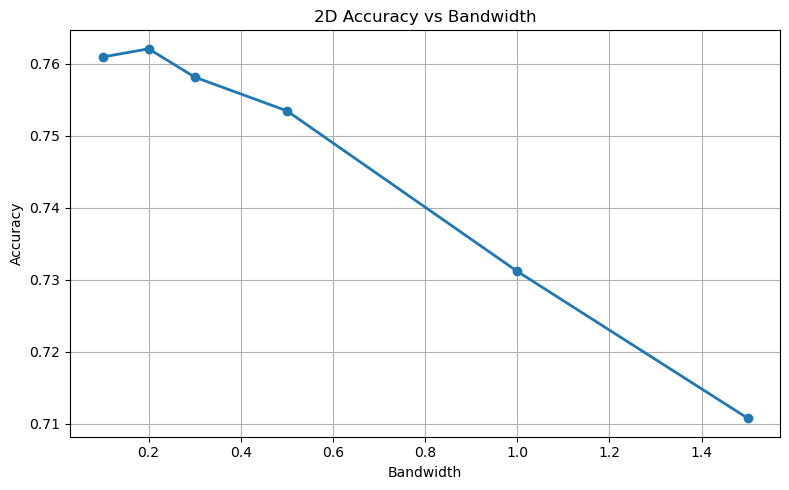

In [257]:
different2DBandwidths(train, test, Bandwidth2DList)

In the 2D KDE model, we see another inverse relationship between prediction accuracy and bandwidth size. The model performs better when the bandwidth is smaller. As the bandwidth increases, the KDE becomes overly smoothed, which reduces the model’s ability to make distinctions between male and female runners based on their finish time and age.

## Part 4: Compare to k-NN

This part uses k_NN classificaiton with the features of both 1D and 2D KDEs and compares the accuracy of the classifier to the Bayes' Theorem predictions. This is a benchmarking step. k-NN is a commonly used non-parametric method, and comparing it to Bayes gives insight into which method works better for this dataset and why.

### Methodology
1. Use k-Nearest Neighbors classification to predict gender using:
    - 1D data (time only)
    - 2D data (time + age)

2. Compare the accuracy with the Bayesian KDE approach.

In [259]:
def knnClassifier1D (train, test, k):                           # Define a function to apply 1D k-NN classification using only finish time

    X_train = train[['Time(mins)']].values                      # Extract training finish times and convert to NumPy array       
    y_train = train['M/F'].values                               # Extract training labels for gender
    
    X_test = test[['Time(mins)']].values                        # Extract testing finish times
    y_test = test['M/F'].values                                 # Extract testing labels for gender

    
    knn = KNeighborsClassifier(n_neighbors=k)                   # Create KNN classifier with k neighbors
    knn.fit(X_train, y_train)                                   # Fit the classifier on training data

    
    predictions = knn.predict(X_test)                           # Predict gender using the trained model
    accuracy = accuracy_score(y_test, predictions)              # Compute accuracy
    print(f'1D k-NN Accuracy (k={k}): {accuracy:.4f}')          # Print accuracy
    
    return accuracy

In [305]:
k_vals = [1, 3, 5, 7, 9, 11]                                       # List of k values

def plotKnn1d(train, test, k_values):                              # Define a function to plot k-NN accuracy
    
    accuracies = []                                                # Create an empty accuracy list
    
    for k in k_values:                                             # Loop through each k value
        acc = knnClassifier1D(train, test, k)                      # Run 1D k-NN classifier for current k
        accuracies.append(acc)                                     # add the accuracy ot the accuracy list
    
    plt.figure(figsize=(8, 5))                                     # plot accuracy vs. k
    plt.plot(k_values, accuracies, marker='o', color='blue')
    plt.title('1D k-NN Accuracy vs. K')
    plt.xlabel('k (Number of Neighbors)')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.xticks(k_values)
    plt.tight_layout()
    plt.show()

1D k-NN Accuracy (k=1): 0.5844
1D k-NN Accuracy (k=3): 0.5973
1D k-NN Accuracy (k=5): 0.6065
1D k-NN Accuracy (k=7): 0.6117
1D k-NN Accuracy (k=9): 0.6143
1D k-NN Accuracy (k=11): 0.6191


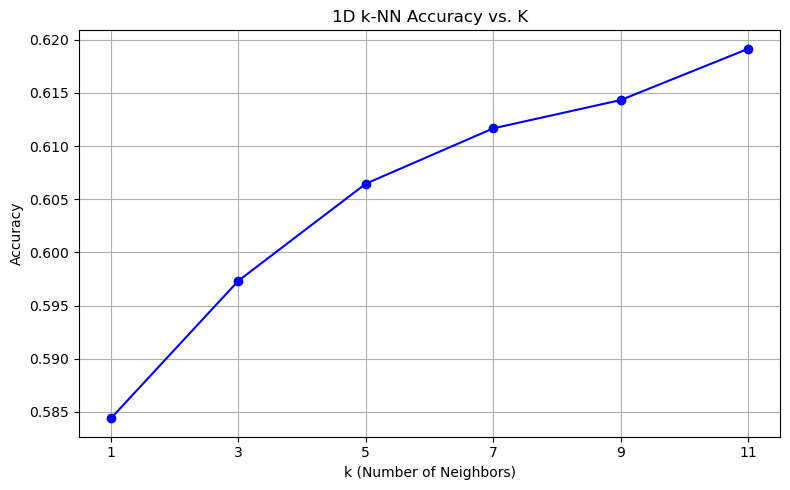

In [307]:
plotKnn1d(train, test, k_vals)

Here, we can see a positive relationship between number of nearest neighbors and accuracy. Accuracy steadily improves as more neighbors are considered.

In [262]:
def knnClassifier2D (train, test, k):                      # Define a function for 2D k-NN classification

    X_train = train[['Time(mins)', 'Age']].values          # Extract training Time and Age
    y_train = train['M/F'].values                          # Extract training labels for gender

    X_test = test[['Time(mins)', 'Age']].values            # Extract testing Time and Age
    y_test = test['M/F'].values                            # Extract testing labels for gender

   
    knn = KNeighborsClassifier(n_neighbors=k)             # Create k-NN classifier with k neighbors
    knn.fit(X_train, y_train)                             # Train classifier on training data
  
    predictions = knn.predict(X_test)                     # Predict labels for test data
    accuracy = accuracy_score(y_test, predictions)        # Compute accuracy of predictions
    print(f'2D k-NN Accuracy (k={k}): {accuracy:.4f}')    # Print accuracy

        return accuracy

In [287]:
k_vals = [1, 3, 5, 7, 9, 11]                                       # List of k values

def plotKnn2D (train, test, k_values):                             # Define a function to plot 2D k-NN accuracy
    
    accuracies = []                                                # Create an empty accuracy list
    
    for k in k_values:                                             # Loop through each k value
        acc = knnClassifier2D(train, test, k)                      # Run 2D k-NN classifier with current k
        accuracies.append(acc)                                     # Add the accuracy to the accuracy list
        
    plt.figure(figsize=(8, 5))                                     # Plot Accuracy vs. Time
    plt.plot(k_values, accuracies, marker='s', color='green')
    plt.title('2D k-NN Accuracy vs. Number of Neighbors')
    plt.xlabel('k (Number of Neighbors)')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.xticks(k_values)
    plt.tight_layout()
    plt.show()

2D k-NN Accuracy (k=1): 0.6843
2D k-NN Accuracy (k=3): 0.7169
2D k-NN Accuracy (k=5): 0.7308
2D k-NN Accuracy (k=7): 0.7366
2D k-NN Accuracy (k=9): 0.7420
2D k-NN Accuracy (k=11): 0.7466


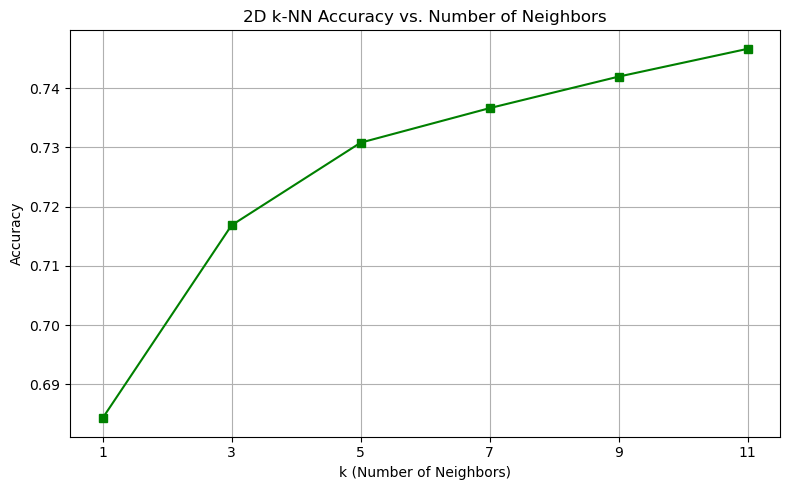

In [302]:
plotKnn2D (train, test, k_vals)

We can see another positive relationship between accuracy an number of neighbors for the 2D k-NN model as well.

When comparing the two k-NN models, we can see that the 2D k-NN model outperforms the 1D model for all values of k. This shows that adding age significantly increases the model's ability to distinguish between male and female runners.

# Conclusion
This project explored how Bayes' Theorem can be used to predice a runner's gender. It then tested how accurate this method was copared to machine learning classifers. 

In the KDE models, we found that smaller bandwidths consistently gave better accuracy. The 2D KDE model used both finishing time and age, performed better than the 1D version, which only used finishing times. This showed that adding a second feature helped improve classification. In both cases, larger bandwidths smoothed the data too much and made it harder for the model to separate male and female runners.

In the k-NN models, we can see that adding more features increases the model's ability to separate male and female runners. The 1D k-NN model, only used one feature - finish time. There is a positive trend showing that accuracy inporoves as the number of neighbors increases. THe 2D model, using age and finishing times, shows the same thing, but ahs better performance.

When comparing KDE to k-NN, the k-NN models outperformed the KDE models overall. The 2D k-NN model achieved the highest accuracy among the tested models. This suggests that while Bayes-based approaches can be effective and provide useful insight into probability distributions, k-NN is better at making accurate predictions on this dataset. 

Overall, adding more relevant features like age improved performance in both methods and tuning parameters like bandwidth or number of neighbors made a clear difference. The 2D k-NN model stands out as the most accurate model.
